## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sarawater as sara

plt.style.use("stylesheet.mplstyle")

## I/O paths and directories creation

In [2]:
input_csv_filepath = os.path.join("data", "daily_discharge_30y.csv")

## Read the discharge data and create a reach object

### Read the CSV data

In [3]:
reach_df = pd.read_csv(input_csv_filepath)

# Convert the first column to datetime
reach_df["Date"] = pd.to_datetime(reach_df["Date"])

# Convert the datetime column to a list of datetime objects
datetime_list = [t.to_pydatetime() for t in reach_df["Date"].tolist()]

# Put the discharge data into a numpy array
discharge_data = np.array(reach_df["Q"].to_list())
discharge_data

array([0.14237922, 0.13967256, 0.13670004, ..., 0.1290903 , 0.12805679,
       0.12684438], shape=(10957,))

### Initialize a reach object

In [4]:
Qab_max = 0.2
my_reach = sara.Reach("My Reach", datetime_list, discharge_data, Qab_max)

## Add scenarios to the reach object

#### Minimum release scenario (read from CSV)

In [5]:
# Read the minimum release values from CSV relative to a Minimum Flow Requirement (MFR) policy
minrel_df = pd.read_csv(
    os.path.join("data", "minimum_flow_requirements.csv"), header=None
)

# Get the minimum release values (second column), convert l/s to m3/s
QR_months = np.array(minrel_df[1].tolist()) / 1000.0

# Create a constant scenario with these values
MFR_scenario = sara.ConstScenario(
    name="MFR",
    description="Minimum Flow Requirement scenario from CSV file",
    reach=my_reach,
    QR_months=QR_months,
)

# Add the scenario to the reach
my_reach.add_scenario(MFR_scenario)

# Print the min and max MFR values
min_mfr = MFR_scenario.QR_months.min()
max_mfr = MFR_scenario.QR_months.max()
print(f"MFR values range from {min_mfr:.3f} to {max_mfr:.3f} [m^3/s]")

MFR values range from 0.090 to 0.106 [m^3/s]


#### Ecological scenario (using the built-in method)

In [6]:
my_reach.add_ecological_flow_scenario(
    "EF", "Ecological Flow Scenario with default parameters"
)

Scenario(name=EF, description=Ecological Flow Scenario with default parameters, reach=My Reach)

#### Let's check we added the scenarios correctly

In [7]:
my_reach.print_scenarios()

scenarios[0]: MFR | Minimum Flow Requirement scenario from CSV file
scenarios[1]: EF | Ecological Flow Scenario with default parameters


## Compute the released flow discharge and abstracted flow for each scenario

In [8]:
for scenario in my_reach.scenarios:
    scenario.compute_QS()
    scenario.compute_natural_abstracted_volumes()

## Habitat analysis

Read Habitat-Discharge curves from input data

In [9]:
HQ_curve_df = pd.read_csv(
    os.path.join("data", "HQ_curves.txt"), sep="\t", header="infer"
)
my_reach.add_HQ_curve(HQ_curve_df)

,DIS,WET,BROW_A_R,MARB_A_R,TROU_J_R
0,0.00,0.00,0.00,0.00,0.00
1,0.16,34.92,6.61,4.55,10.91
2,0.32,69.84,13.23,9.09,21.83
3,0.47,80.86,13.84,13.05,14.18
4,0.63,85.51,14.72,15.29,10.11
5,0.79,86.41,16.34,16.03,10.81
6,0.95,87.30,17.96,16.77,11.50
7,1.11,88.19,19.58,17.51,12.20
8,1.27,89.27,20.82,18.04,12.67
9,1.42,91.95,18.82,16.73,11.27


In [10]:
my_reach.get_list_available_HQ_curves()

['BROW_A_R', 'MARB_A_R', 'TROU_J_R']

Compute IH for each species and scenario

In [11]:
for scenario in my_reach.scenarios:
    scenario.compute_IH_for_species()
    for species in scenario.IH.keys():
        print(
            f"Scenario {scenario.name}, Species {species}, IH: {scenario.IH[species]['IH']}"
        )

Scenario MFR, Species BROW_A_R, IH: 0.15577265510659258
Scenario MFR, Species MARB_A_R, IH: 0.07702982228117508
Scenario MFR, Species TROU_J_R, IH: 0.669112667411991
Scenario EF, Species BROW_A_R, IH: 0.28378208424489687
Scenario EF, Species MARB_A_R, IH: 0.07287254992102295
Scenario EF, Species TROU_J_R, IH: 0.7244099452005035


## Draw Plots

Initialize a `ReachPlotter` object

In [12]:
plotter = sara.ReachPlotter(my_reach)

Full HQ curves

<Axes: title={'center': 'Habitat-Discharge (HQ) curves'}, xlabel='Q $[\\mathrm{m}^3/\\mathrm{s}]$', ylabel='Available area $[\\mathrm{m}^2]$'>

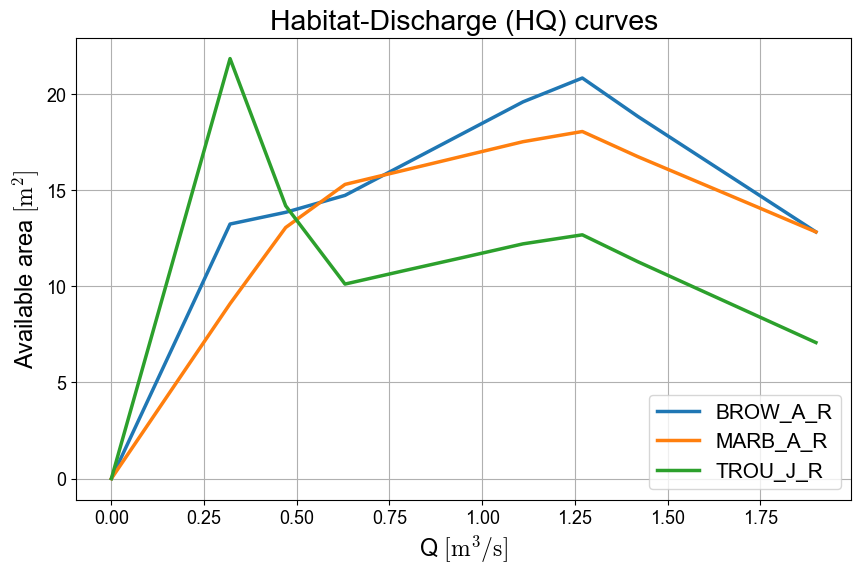

In [13]:
plotter.plot_hq_curves()

HQ curves setting xlim, and showing the DMV (or another constant scenario) range

<Axes: title={'center': 'Habitat-Discharge (HQ) curves'}, xlabel='Q $[\\mathrm{m}^3/\\mathrm{s}]$', ylabel='Available area $[\\mathrm{m}^2]$'>

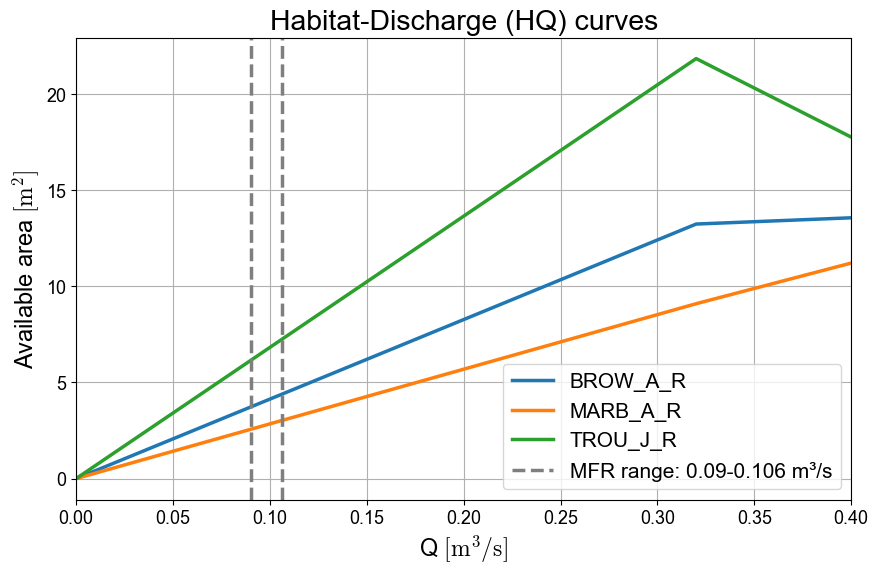

In [14]:
plotter.plot_hq_curves(xlim=0.4, rule_min=min_mfr, rule_max=max_mfr, rule_name="MFR")

Habitat timeseries

In [15]:
my_reach.get_list_available_HQ_curves()

['BROW_A_R', 'MARB_A_R', 'TROU_J_R']

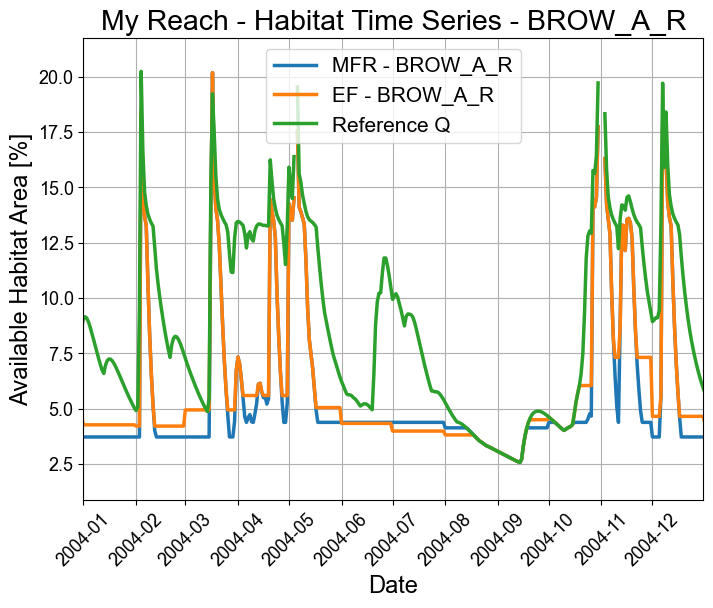

In [16]:
plotter.plot_habitat_timeseries("BROW_A_R", start_year=2004, end_year=2004, save=True)

UCUT

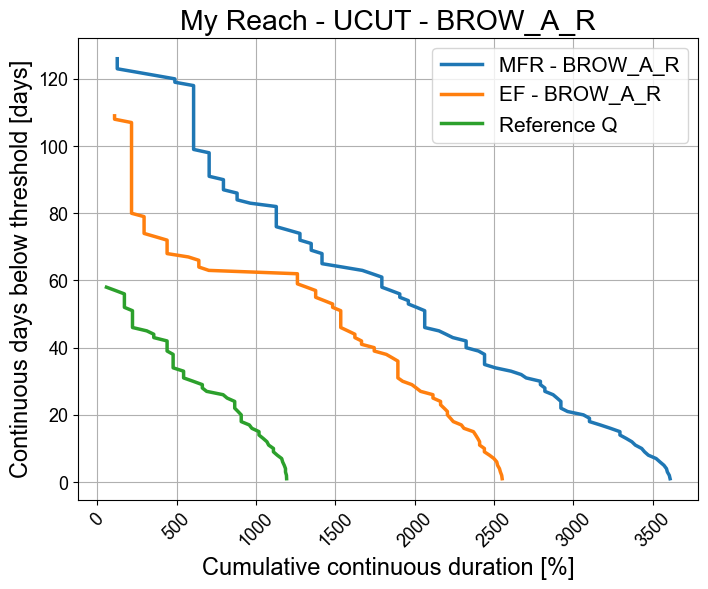

In [17]:
plotter.plot_ucut_curves("BROW_A_R")

IH_vs_volume

<Axes: title={'center': 'My Reach - IH vs Abstracted Volume'}, xlabel='Habitat Index $(IH)$ [-]', ylabel='Normalized abstracted volume $V_{der}/V_{nat}$ [-]'>

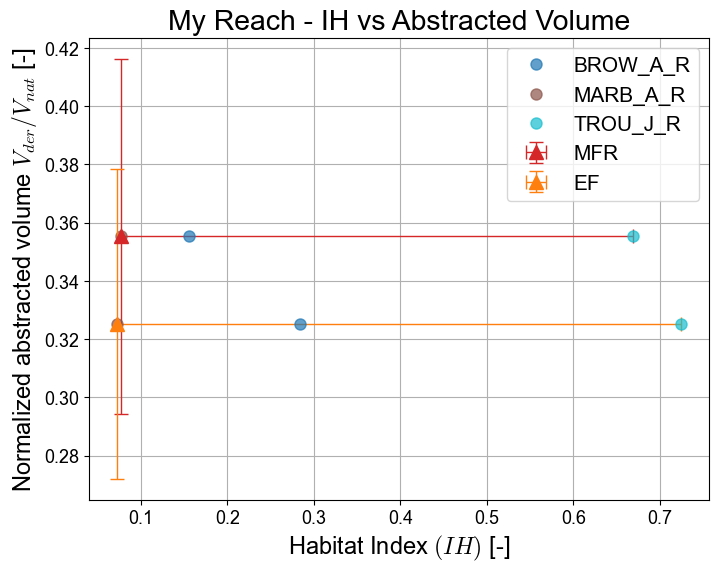

In [18]:
plotter.plot_ih_vs_volume(save=True)